## Análisis exploratorio de datos - Properati

In [10]:
# magic function para hacer que los graficos de matplotlib se renderizen en el notebook.
%matplotlib inline

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default') # haciendo los graficos un poco mas bonitos xD
plt.rcParams['figure.figsize'] = (15, 5)

In [243]:
# carga de un data frame
propiedades = pd.read_csv('./datasets/properati-AR-2017-08-01-properties-sell.csv', sep=',', error_bad_lines=False, low_memory=False)
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187482 entries, 0 to 187481
Data columns (total 27 columns):
id                            187482 non-null object
created_on                    187482 non-null object
operation                     187482 non-null object
property_type                 187482 non-null object
place_name                    187447 non-null object
place_with_parent_names       187482 non-null object
country_name                  187482 non-null object
state_name                    187482 non-null object
geonames_id                   158318 non-null float64
lat-lon                       118761 non-null object
lat                           118761 non-null float64
lon                           118761 non-null float64
price                         154443 non-null float64
currency                      154441 non-null object
price_aprox_local_currency    154443 non-null float64
price_aprox_usd               154443 non-null float64
surface_total_in_m2           12502

In [13]:
propiedades.head(5)

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,93.0,360.360360,1290.322581,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS...,CASA EN VENTA,https://thumbs4.properati.com/1/ufoyqwscVk8n3e...
1,a205c53378e7879cf7519659317fb410c060d20e,2012-10-22,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,220.0,1000.000000,1000.000000,NaN,NaN,NaN,http://www.properati.com.ar/20hi_venta_casa_me...,CHALET VENTA 4 AMBIENTES PADUA.EXCELENTE CHALE...,CASA EN VENTA,https://thumbs4.properati.com/5/I5RS_jAIUseo9H...
2,e06d6f864a0b91346594da4d27ceddcef0947ea6,2012-11-01,sell,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3430863.0,"-38.0199509,-57.5265733",...,42.0,NaN,NaN,NaN,2.0,NaN,http://www.properati.com.ar/336o_venta_departa...,DTO. 2 AMB. C/ VISTA PLENA AL 6 X 3DOMITORIO ...,DTO. 2 AMB. C/ VISTA PLENA AL MAR,https://thumbs4.properati.com/5/VjDOdzm9n8uqZu...
3,a07927207d2a03de5f4ba7fd76f670d6285a3315,2012-11-26,sell,house,Sierra de los Padres,|Argentina|Buenos Aires Interior|General Pueyr...,Argentina,Buenos Aires Interior,3427958.0,"-37.9511934894,-57.7752885836",...,265.0,NaN,NaN,NaN,6.0,NaN,http://www.properati.com.ar/47hc_venta_terreno...,PROPIEDAD DE CATEGORIA CUENTA CON: 4 DORMITOR...,CHALET EN VENTA,https://thumbs4.properati.com/9/DA4GMdxXrthh5z...
4,9446052c949050359fb08b9f1ba83ba2eaa20c99,2012-12-08,sell,house,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6544492346,-58.4895603251",...,103.0,616.666667,1796.116505,NaN,5.0,NaN,http://www.properati.com.ar/4m4m_venta_casa_ma...,Casa Multifamiliar en Mataderos!!! Sobre lote ...,CASA EN VENTA,https://thumbs4.properati.com/6/DsNJjCb5_zIPV0...


In [14]:
# Analizamos los diferentes valores que puede tomar state_name para hacer el filtro correctamente y no perder información
propiedades.loc[:, 'state_name'].value_counts()

Capital Federal                 44152
Bs.As. G.B.A. Zona Norte        39888
Bs.As. G.B.A. Zona Oeste        22571
Buenos Aires Costa Atlántica    20694
Bs.As. G.B.A. Zona Sur          18135
Córdoba                         15777
Santa Fe                        13516
Buenos Aires Interior            4686
Río Negro                        1152
Neuquén                          1057
Mendoza                           927
Misiones                          817
Entre Ríos                        793
Tucumán                           715
Corrientes                        629
San Luis                          444
Salta                             372
Chubut                            329
La Pampa                          301
Catamarca                         126
Chaco                              95
San Juan                           86
Tierra Del Fuego                   69
Formosa                            66
Santa Cruz                         40
Jujuy                              32
La Rioja    

In [ ]:
prop_caba_gba = propiedades[propiedades['state_name'].str.contains('Capital Federal') | propiedades['state_name'].str.contains('G.B.A.')]
prop_caba_gba.head(5)

In [8]:
prop_caba_gba.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124746 entries, 0 to 187480
Data columns (total 27 columns):
id                            124746 non-null object
created_on                    124746 non-null object
operation                     124746 non-null object
property_type                 124746 non-null object
place_name                    124711 non-null object
place_with_parent_names       124746 non-null object
country_name                  124746 non-null object
state_name                    124746 non-null object
geonames_id                   97866 non-null float64
lat-lon                       75504 non-null object
lat                           75504 non-null float64
lon                           75504 non-null float64
price                         110203 non-null float64
currency                      110202 non-null object
price_aprox_local_currency    110203 non-null float64
price_aprox_usd               110203 non-null float64
surface_total_in_m2           89385 non

### Ventas por localidad

In [203]:
prop_barrio = prop_caba_gba['state_name'].value_counts()
prop_barrio

Capital Federal             44152
Bs.As. G.B.A. Zona Norte    39888
Bs.As. G.B.A. Zona Oeste    22571
Bs.As. G.B.A. Zona Sur      18135
Name: state_name, dtype: int64

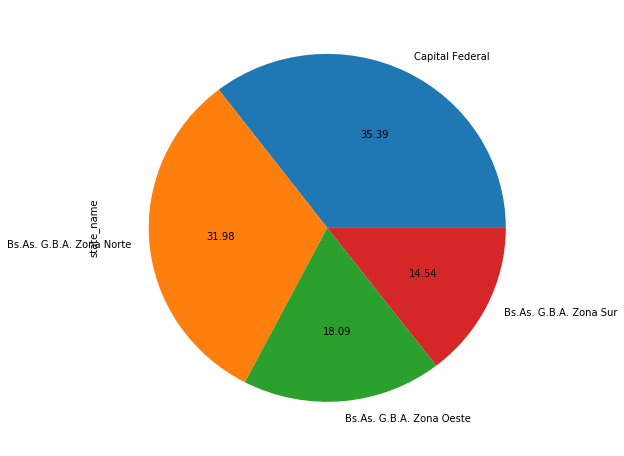

In [204]:
%matplotlib inline
plt.figure()
#comparar porcentaje y totales
prop_barrio.plot.pie(figsize=(8, 8),autopct='%.2f')

In [206]:
def parsear_zona(row):
    mylist = row['place_with_parent_names'].split("|")
    return mylist[3]

prop_caba_gba.loc[:,'neighborhood'] = prop_caba_gba.apply(parsear_zona, axis=1)   
prop_caba_gba.head(5)

,id,created_on,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,...,rooms,expenses,properati_url,description,title,image_thumbnail,neighborhood,created_on_dt,year,month
0,c8a66ee9e3da083ab66dacd165e8a5cc718b1cf2,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,CASA CON LOCAL EN VENTA EN PADUA.2 DORMITORIOS...,CASA EN VENTA,https://thumbs4.properati.com/1/ufoyqwscVk8n3e...,Merlo,2012-09-19,2012,9
1,a205c53378e7879cf7519659317fb410c060d20e,2012-10-22,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,Argentina,Bs.As. G.B.A. Zona Oeste,3429244.0,NaN,...,NaN,NaN,http://www.properati.com.ar/20hi_venta_casa_me...,CHALET VENTA 4 AMBIENTES PADUA.EXCELENTE CHALE...,CASA EN VENTA,https://thumbs4.properati.com/5/I5RS_jAIUseo9H...,Merlo,2012-10-22,2012,10
4,9446052c949050359fb08b9f1ba83ba2eaa20c99,2012-12-08,sell,house,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6544492346,-58.4895603251",...,5.0,NaN,http://www.properati.com.ar/4m4m_venta_casa_ma...,Casa Multifamiliar en Mataderos!!! Sobre lote ...,CASA EN VENTA,https://thumbs4.properati.com/6/DsNJjCb5_zIPV0...,Mataderos,2012-12-08,2012,12
5,4d3b492ed5f9c74cdf33b56b98328e5c950e3f9c,2013-01-04,sell,apartment,Pilar,|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|,Argentina,Bs.As. G.B.A. Zona Norte,3429979.0,"-34.429071,-58.795418",...,2.0,NaN,http://www.properati.com.ar/518a_venta_departa...,"Venta - Departamento - Argentina, Buenos Aires...",Departamento en Venta ubicado en Arcos de Pilar,https://thumbs4.properati.com/8/bJn9FqcBRGi_8H...,Pilar,2013-01-04,2013,1
6,535441f569473f6e5d687c38b27d9b9c6e69e284,2013-01-09,sell,store,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro|,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0,"-34.4789383,-58.5214371",...,1.0,NaN,http://www.properati.com.ar/52p4_venta_local_s...,"Venta - Local - Argentina, Buenos Aires, Zona ...",Local en Venta ubicado en San Isidro,https://thumbs4.properati.com/9/ZCK2RkrsymyN5s...,San Isidro,2013-01-09,2013,1


### Top ventas por barrio

In [208]:
prop_localidad = prop_caba_gba['neighborhood'].value_counts().head(10)

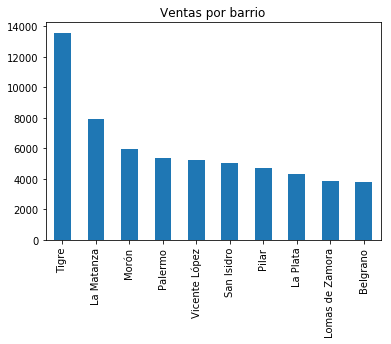

In [209]:
%matplotlib inline
#%matplotlib notebook
# top 20
prop_localidad.plot('bar', title = 'Ventas por barrio')

In [210]:
prop_caba_gba['property_type'].value_counts()

apartment    68826
house        44258
PH            7045
store         4617
Name: property_type, dtype: int64

In [211]:
moneda = prop_caba_gba['currency'].value_counts()
moneda

USD    105677
ARS      4523
PEN         2
Name: currency, dtype: int64

### Valor de las propiedades por barrio o partido

In [212]:
data = prop_caba_gba.loc[:,['neighborhood', 'price_aprox_usd']]
data.dropna(inplace=True)
group_by_barrio = data.groupby('neighborhood').agg([np.mean, np.size])
group_by_barrio = group_by_barrio.loc[group_by_barrio[('price_aprox_usd','size')] > 50].sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_barrio.head(10)

price_aprox_usd         
                             mean     size
neighborhood                              
Puerto Madero       933102.405806   1030.0
San Isidro          453277.572763   4900.0
Recoleta            451190.720953   1889.0
                    401593.354604   2515.0
Retiro              395079.866257    350.0
Tigre               381874.766485  12795.0
Belgrano            378185.525543   3276.0
Palermo             372118.074596   4687.0
Nuñez               370172.824995    933.0
General Rodríguez   364753.685656    221.0

In [213]:
data_barrio = prop_caba_gba.loc[:,['place_name', 'price_aprox_usd']]
data_barrio.dropna(inplace=True)
group_by_place = data_barrio.groupby('place_name').agg([np.mean, np.size])
group_by_place = group_by_place.loc[group_by_place[('price_aprox_usd','size')] > 50].sort_values(('price_aprox_usd','mean'), ascending=False)
group_by_place.head(10)

price_aprox_usd        
                                        mean    size
place_name                                          
Palermo Chico                   1.084513e+06   270.0
Puerto Madero                   9.331024e+05  1030.0
Santa Barbara Barrio Cerrado    7.815383e+05   115.0
Acassuso                        7.100821e+05   431.0
Barrio Los Lagos                6.151161e+05    62.0
Mayling Club de Campo           5.429888e+05    89.0
Martínez                        4.724978e+05  1689.0
Capital Federal                 4.648952e+05  1800.0
Recoleta                        4.511907e+05  1889.0
Vicente López                   4.494558e+05   929.0

### Cantidad de ventas de propiedades por año y mes

In [214]:
ventas_por_anio = prop_caba_gba
ventas_por_anio['year'] = pd.to_datetime(prop_caba_gba.loc[:,'created_on']).dt.year
ventas_por_anio = ventas_por_anio.groupby('year').count()['created_on']
ventas_por_anio

/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


year
2012        3
2013      417
2014     4348
2015    10208
2016    24730
2017    85040
Name: created_on, dtype: int64

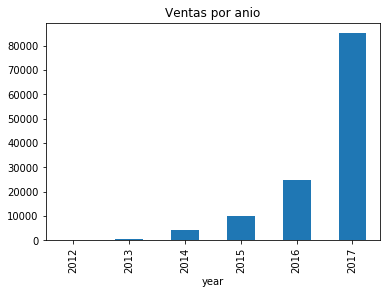

In [185]:
%matplotlib inline
#%matplotlib notebook
# top 20
ventas_por_anio.plot('bar', title = 'Ventas por anio')

In [194]:
ventas_por_mes = prop_caba_gba
ventas_por_mes['year'] = pd.to_datetime(prop_caba_gba.loc[:,'created_on']).dt.year
ventas_por_mes['month'] = pd.to_datetime(prop_caba_gba.loc[:,'created_on']).dt.month
ventas_por_mes = ventas_por_mes.groupby(['year', 'month']).count()['created_on']
ventas_por_mes.head(10)

/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


year  month
2012  9          1
      10         1
      12         1
2013  1          3
      2          2
      3          9
      4          3
      5        229
      6         19
      7         28
Name: created_on, dtype: int64

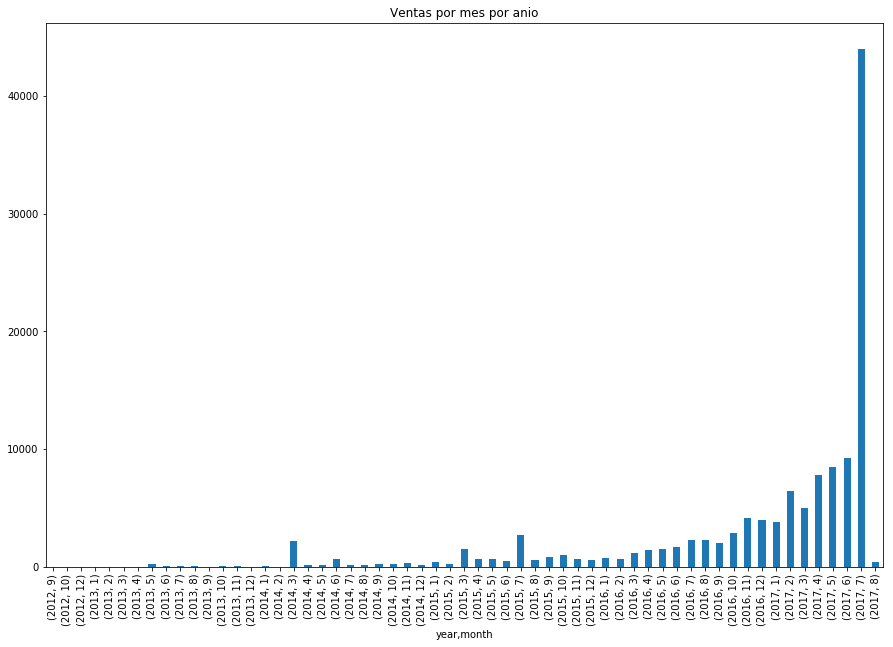

In [199]:
%matplotlib inline
#%matplotlib notebook
# top 20
ventas_por_mes.plot('bar', title = 'Ventas por mes por anio', figsize=(15,10))

### Tipos de propiedad vendidas

In [220]:
ventas_por_tipo = prop_caba_gba
ventas_por_tipo['year'] = pd.to_datetime(prop_caba_gba.loc[:,'created_on']).dt.year
ventas_por_tipo = ventas_por_tipo.groupby(['year','property_type']).count()['created_on']
ventas_por_tipo.head(10)

/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


year  property_type
2012  house               3
2013  PH                 34
      apartment         193
      house             181
      store               9
2014  PH                351
      apartment        1768
      house            2011
      store             218
2015  PH                712
Name: created_on, dtype: int64

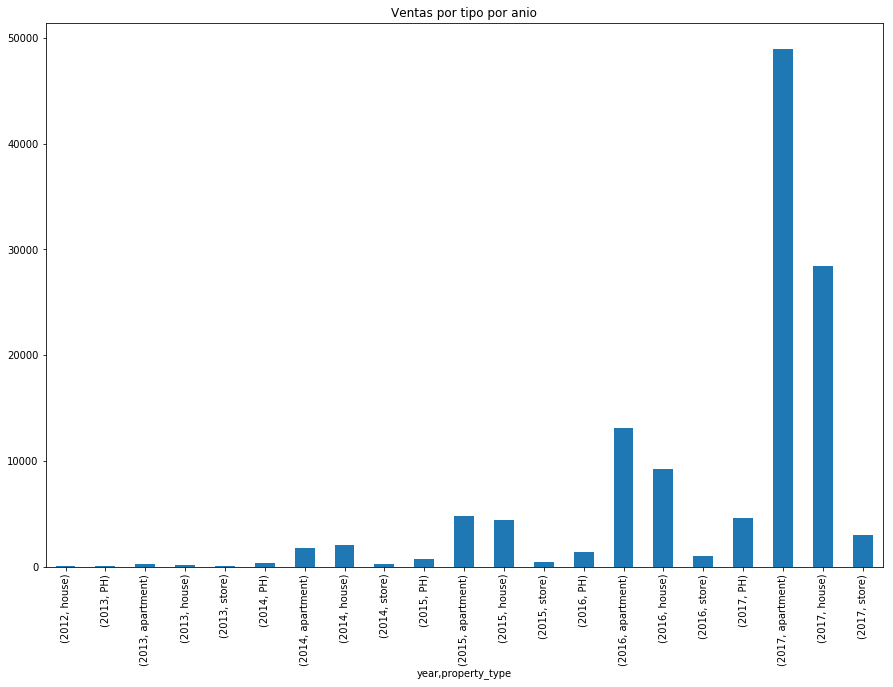

In [221]:
%matplotlib inline
#%matplotlib notebook
# top 20
ventas_por_tipo.plot('bar', title = 'Ventas por tipo por anio', figsize=(15,10))

### Evolución de ventas de departamentos por año

In [229]:
ventas_dptos = prop_caba_gba[prop_caba_gba['property_type'] == 'apartment']
ventas_dptos['year'] = pd.to_datetime(ventas_dptos.loc[:,'created_on']).dt.year
ventas_dptos['month'] = pd.to_datetime(ventas_dptos.loc[:,'created_on']).dt.month
ventas_dptos = ventas_dptos.groupby(['year', 'month']).count()['created_on']
ventas_dptos.head(10)

/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


year  month
2013  1         2
      2         1
      3         6
      4         2
      5        98
      6         9
      7        12
      8        34
      9         7
      10        9
Name: created_on, dtype: int64

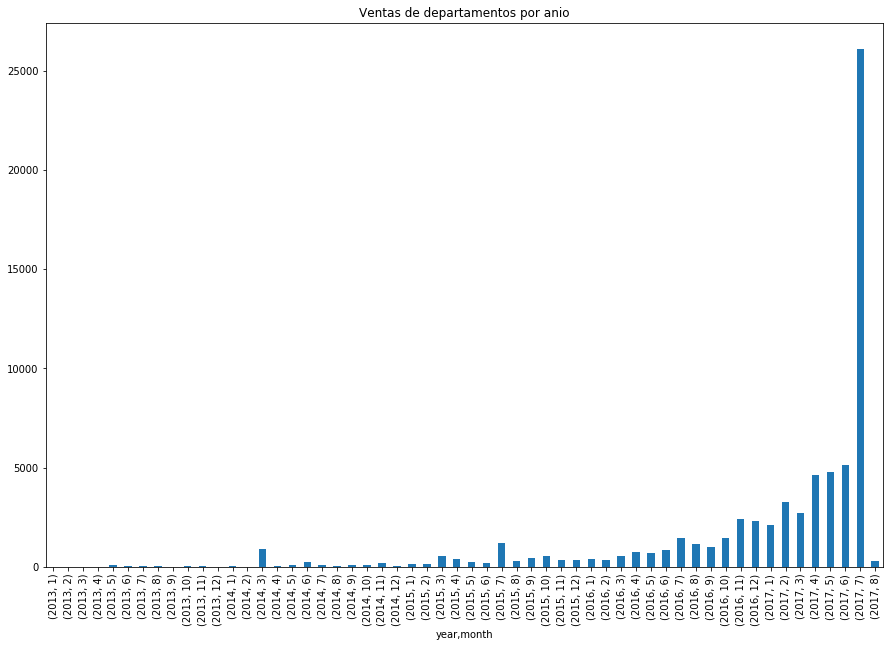

In [266]:
%matplotlib inline
#%matplotlib notebook
# top 20
ventas_dptos.plot('bar', title = 'Ventas de departamentos por anio', figsize=(15,10))

## Comunas

In [30]:
# carga de un data frame
comunas = pd.read_csv('datasets/comunas.csv', sep=',', error_bad_lines=False, low_memory=False)
comunas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
WKT          15 non-null object
BARRIOS      15 non-null object
PERIMETRO    15 non-null float64
AREA         15 non-null float64
COMUNAS      15 non-null int64
dtypes: float64(2), int64(1), object(2)
memory usage: 672.0+ bytes


In [31]:
comunas

,WKT,BARRIOS,PERIMETRO,AREA,COMUNAS
0,MULTIPOLYGON (((-58.395205797051254 -34.572190...,RECOLETA,21246.611702,6.140873e+06,2
1,MULTIPOLYGON (((-58.412870031308849 -34.614116...,ALMAGRO - BOEDO,12323.465538,6.660526e+06,5
2,MULTIPOLYGON (((-58.430605828330876 -34.607047...,CABALLITO,10990.964471,6.851029e+06,6
3,MULTIPOLYGON (((-58.451995245456509 -34.629745...,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,7
4,MULTIPOLYGON (((-58.519254053232501 -34.633010...,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,9
5,MULTIPOLYGON (((-58.488337367324576 -34.620160...,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,10
6,MULTIPOLYGON (((-58.498384839883038 -34.596367...,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,11
7,MULTIPOLYGON (((-58.503311325084404 -34.593856...,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,12
8,MULTIPOLYGON (((-58.426759317276407 -34.552023...,PALERMO,21768.074886,1.577250e+07,14
9,MULTIPOLYGON (((-58.41191880980378 -34.5980030...,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,3


## Subtes

In [34]:
# carga de un data frame
subtes = pd.read_csv('datasets/estaciones-de-subte.csv', sep=',', error_bad_lines=False, low_memory=False)
subtes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 5 columns):
X           86 non-null float64
Y           86 non-null float64
ID          86 non-null float64
ESTACION    86 non-null object
LINEA       86 non-null object
dtypes: float64(3), object(2)
memory usage: 3.4+ KB


In [36]:
subtes.head(10)

,X,Y,ID,ESTACION,LINEA
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1�,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COL�N,D
8,-58.407161,-34.591628,9.0,AG�ERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


## Ferrocarriles

In [35]:
# carga de un data frame
ferrocarriles_caba = pd.read_csv('datasets/estaciones-de-ferrocarril.csv', sep=';', error_bad_lines=False, low_memory=False)
ferrocarriles_caba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 9 columns):
LAT        47 non-null float64
LNG        47 non-null float64
ID         47 non-null int64
NOMBRE     47 non-null object
EMPRESA    43 non-null object
LINEA      47 non-null object
LINEA_2    47 non-null object
BARRIO     47 non-null object
COMUNA     47 non-null object
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ KB


In [37]:
ferrocarriles_caba.head(10)

,LAT,LNG,ID,NOMBRE,EMPRESA,LINEA,LINEA_2,BARRIO,COMUNA
0,-34.571334,-58.424295,2,3 DE FEBRERO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
1,-34.567571,-58.463056,4,BELGRANO R,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
2,-34.562549,-58.435864,6,LISANDRO DE LA TORRE,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,PALERMO,COMUNA 14
3,-34.558443,-58.449498,7,BELGRANO C,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,BELGRANO,COMUNA 13
4,-34.548895,-58.462400,8,NUÑEZ,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
5,-34.537522,-58.467586,9,RIVADAVIA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,NUÑEZ,COMUNA 13
6,-34.580456,-58.501732,10,PUEYRREDON,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA PUEYRREDON,COMUNA 12
7,-34.574767,-58.487968,11,GRAL. URQUIZA,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
8,-34.568421,-58.479083,12,DR. L. M. DRAGO,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,VILLA URQUIZA,COMUNA 12
9,-34.565240,-58.475348,13,COGHLAN,TBA - TRENES DE BS AS S.A.,MITRE,F.C.G.B.M.,COGHLAN,COMUNA 12


## Espacios verdes públicos

In [38]:
# carga de un data frame
espacio_verde_caba = pd.read_csv('datasets/espacio-verde-publico.csv', sep=',', error_bad_lines=False, low_memory=False)
espacio_verde_caba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571 entries, 0 to 1570
Data columns (total 32 columns):
WKT           1571 non-null object
NOMBRE        848 non-null object
NOMBRE_EV     1373 non-null object
CLASIFICAC    1570 non-null object
PATIO_DE_J    1399 non-null object
APADRINADA    720 non-null object
OBSERVACIO    942 non-null object
FUENTE_GEO    1530 non-null object
FUENTE_INS    1516 non-null object
UBICACION     1481 non-null object
DECRETO       449 non-null object
FECHA_DECR    487 non-null object
ORDENANZA_    657 non-null object
FECHA_ORDE    694 non-null object
BOLETIN_OF    724 non-null object
FECHA_BOLE    724 non-null object
BARRIO        1569 non-null object
COMUNA        1571 non-null float64
FECH_PADRI    71 non-null object
VIG_PADRI     70 non-null object
ALC_CONVEN    70 non-null object
NOM_MAPA      847 non-null object
ID_EV_PUB     1571 non-null int64
AREA          1571 non-null float64
PERIMETER     1571 non-null float64
DGEV_PADRI    81 non-null object

In [39]:
espacio_verde_caba.head(10)

,WKT,NOMBRE,NOMBRE_EV,CLASIFICAC,PATIO_DE_J,APADRINADA,OBSERVACIO,FUENTE_GEO,FUENTE_INS,UBICACION,...,ID_EV_PUB,AREA,PERIMETER,DGEV_PADRI,MANT_2017,TAREAS,ESTADO,SUP_TOTAL,CANIL,POSTA_AERO
0,MULTIPOLYGON (((-58.4451555904981 -34.57906477...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,1,295.339,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MULTIPOLYGON (((-58.4453556017045 -34.57924873...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,2,774.284,9990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MULTIPOLYGON (((-58.4448487613474 -34.57975070...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,3,26.081,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MULTIPOLYGON (((-58.4452130902327 -34.58012665...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,4,4279.665,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MULTIPOLYGON (((-58.4448127670184 -34.57989117...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,5,3.984,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,MULTIPOLYGON (((-58.4451875792257 -34.58001358...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,6,5194.855,9600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,MULTIPOLYGON (((-58.4452896627963 -34.57898463...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"CONDE - MATIENZO, BENJAMIN, TTE. - FREIRE, RAM...",...,7,588.643,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,MULTIPOLYGON (((-58.4382360541145 -34.54616199...,NaN,SIN NOMBRE,PLAZOLETA,NO,NaN,ESPACIOS VERDES,USIG,USIG,"GUIRALDES, INTENDENTE - ESTACIONAMIENTO - PARQ...",...,8,3746.965,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MULTIPOLYGON (((-58.4552876770316 -34.56223232...,PZA. RAFAEL HERNANDEZ,"HERNANDEZ, RAFAEL",PLAZA,SI,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - VUELTA DE OBLIGADO - MOM, POLICARPO",...,9,558.986,9990.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,MULTIPOLYGON (((-58.4371387094279 -34.55314301...,PZA. PQUES. NACIONALES ARGENTINOS,PARQUES NACIONALES ARGENTINOS,PLAZA,NO,NO,NaN,ESPACIOS VERDES,E.V.,"ECHEVERRIA - CASTAÑEDA - SUCRE, ANTONIO J. DE,...",...,10,12169.958,1000.0,SI,SI,PARQUIZACION - VEREDAS PERIMETRALES,FINALIZADA,10215.0,NaN,NaN


## Establecimientos educativos

In [40]:
# carga de un data frame
establecimientos_educativos = pd.read_csv('datasets/establecimientos-educativos.csv', sep=';', error_bad_lines=False, low_memory=False)
establecimientos_educativos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 28 columns):
LON           2857 non-null float64
LAT           2857 non-null float64
OBJECTID      2857 non-null int64
CUI           2857 non-null int64
CUEANEXO      2857 non-null int64
CUE           2857 non-null int64
ANEXO         2857 non-null float64
SECTOR        2857 non-null int64
DOM_EDIFIC    2857 non-null object
DOM_ESTABL    2857 non-null object
NOMB_EST      2857 non-null object
NOMB_ABR      2857 non-null object
TELEFONO      2854 non-null object
EMAIL         2855 non-null object
CODPOST       2857 non-null object
PAGINAWEB     2857 non-null object
NIVMOD        2857 non-null object
NIVELMODAL    2857 non-null object
DEPFUN        2822 non-null object
DE            2857 non-null int64
COMUNA        2857 non-null int64
BARRIO        2857 non-null object
AREAPROGRA    2857 non-null object
ESTADO        2857 non-null int64
POINT_X       2857 non-null object
POINT_Y       2857 non-

In [41]:
establecimientos_educativos.head(5)

,LON,LAT,OBJECTID,CUI,CUEANEXO,CUE,ANEXO,SECTOR,DOM_EDIFIC,DOM_ESTABL,...,DEPFUN,DE,COMUNA,BARRIO,AREAPROGRA,ESTADO,POINT_X,POINT_Y,NIVEL,TIPEST
0,-58.512702,-34.600586,1,200794,20046500,200465,0.0,1,MERCEDES 4002,MERCEDES 4002,...,DIR DE EDUCACION DEL ADULTO Y DEL ADOLESCENTE,17,11,VILLA DEVOTO,12 - HOSP ZUBIZARRETA,1,9.546.838.350.000.000,10.318.093.010.000.000,SECUNDARIO DE JOVENES Y ADULTOS,CENS (CENTRO EDUCATIVO DE NIVEL SECUNDARIO)
1,-58.409572,-34.627545,2,202368,20146700,201467,0.0,2,CONSTITUCION 3156,CONSTITUCION 3156,...,DIR GRAL DE EDUCACION DE GESTION PRIVADA,6,3,SAN CRISTOBAL,08 - HOSP RAMOS MEJIA,1,10.492.682.829.999.900,10.019.007.170.000.000,SECUNDARIO COMUN,IEIEO (INSTITUTO EDUCATIVO INCORPORADO A LA EN...
2,-58.470192,-34.565676,3,202343,20055900,200559,0.0,1,BLANCO ENCALADA 3479,BLANCO ENCALADA 3471,...,DIR DE EDUCACION INICIAL,10,13,BELGRANO,07 - HOSP PIROVANO,1,9.936.747.400.000.000,10.705.470.920.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
3,-58.400357,-34.584847,4,200063,20290700,202907,0.0,1,AVDA. GRAL. LAS HERAS 2670,AVDA. GRAL. LAS HERAS 2670,...,DIR DE EDUCACION INICIAL,1,2,RECOLETA,04 - HOSP FERNANDEZ,1,10.577.479.859.999.900,10.492.624.360.000.000,INICIAL COMUN,EI (ESCUELA INFANTIL)
4,-58.426547,-34.603379,5,200084,20147803,201478,3.0,1,OBRERO ROBERTO NUÑEZ 4355,OBRERO ROBERTO NUÑEZ 4355,...,DIR DE EDUCACION INICIAL,2,5,ALMAGRO,03 - HOSP DURAND,1,10.337.119.110.000.000,10.287.160.520.000.000,INICIAL COMUN,JIN (JARDIN DE INFANTES NUCLEADO)


## Evolución del dolar

In [86]:
# carga de un data frame
evol_dolar = pd.read_csv('datasets/evol_dolar.csv', sep=',', error_bad_lines=False, low_memory=False)
evol_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 4 columns):
Fecha               2456 non-null object
Tipo de dólar       2456 non-null object
Precio de venta     2456 non-null float64
Precio de compra    1421 non-null float64
dtypes: float64(2), object(2)
memory usage: 76.8+ KB


In [263]:
# data_fecha = evol_dolar.set_index('Fecha')
fecha_1 = dt.datetime(2013, 1, 1).strftime("%d/%m/%y")
evol_dolar = evol_dolar[evol_dolar['Fecha'] > fecha_1]
evol_dolar["Fecha"]=pd.to_datetime(evol_dolar["Fecha"])
evol_dolar = evol_dolar[evol_dolar['Fecha'] > '2013/01/01']

In [277]:
evol_dolar_inf = evol_dolar[evol_dolar['Tipo de d\xc3\xb3lar'] == 'Informal']
evol_dolar_inf.head(10)

,Fecha,Tipo de dólar,Precio de venta,Precio de compra
1003,2013-01-25,Informal,7.62,NaN
1005,2013-01-27,Informal,7.66,NaN
1007,2013-01-28,Informal,7.66,NaN
1009,2013-01-29,Informal,7.80,NaN
1011,2013-01-30,Informal,7.93,NaN
1036,2013-02-25,Informal,7.80,7.78
1039,2013-02-26,Informal,7.82,7.78
1041,2013-02-27,Informal,7.82,7.80
1043,2013-02-28,Informal,7.84,7.82
1075,2013-03-25,Informal,8.35,8.22


In [283]:
# dolar_inf = evol_dolar_inf
# dolar_inf['year'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.year
# dolar_inf['month'] = pd.to_datetime(evol_dolar_inf.loc[:,'Fecha']).dt.month
# dolar_inf.head(10)

/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lcabrera/orga-datos/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Fecha,Tipo de dólar,Precio de venta,Precio de compra,year,month
1003,2013-01-25,Informal,7.62,NaN,2013,1
1005,2013-01-27,Informal,7.66,NaN,2013,1
1007,2013-01-28,Informal,7.66,NaN,2013,1
1009,2013-01-29,Informal,7.80,NaN,2013,1
1011,2013-01-30,Informal,7.93,NaN,2013,1
1036,2013-02-25,Informal,7.80,7.78,2013,2
1039,2013-02-26,Informal,7.82,7.78,2013,2
1041,2013-02-27,Informal,7.82,7.80,2013,2
1043,2013-02-28,Informal,7.84,7.82,2013,2
1075,2013-03-25,Informal,8.35,8.22,2013,3
